In [1]:
import pandas as pd
d = pd.read_csv('C:/Users/jingy/Jupyter/Crime/RWF_fight/CDI_Based/Intensity/CSV/Gray.csv',index_col=0)
display(d.head())

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,Class
0,0.000000,0.028272,0.290819,0.256019,0.791606,0.695249,0.183270,0.165141,0.475022,0.355698,...,0.602157,0.269717,0.198892,0.784086,1.000000,0.092684,0.095424,0.336112,0.293151,0
1,0.032305,0.009882,0.355736,0.202318,0.687148,1.000000,0.064040,0.045861,0.152974,0.058529,...,0.000000,0.108064,0.084753,0.837081,0.992842,0.024197,0.002217,0.324064,0.099132,0
2,0.222071,0.008280,0.244439,0.775828,0.196861,0.114063,0.059441,0.056846,0.200074,0.248023,...,0.044241,0.000000,0.022368,0.387914,0.723925,0.296713,0.565373,0.931537,1.000000,0
3,1.000000,0.669419,0.545547,0.516516,0.478801,0.575175,0.750639,0.684233,0.618253,0.406521,...,0.754214,0.584710,0.522816,0.816022,0.526307,0.246382,0.488166,0.411119,0.000000,0
4,1.000000,0.228268,0.156742,0.169678,0.068515,0.048597,0.057358,0.019576,0.019028,0.071458,...,0.452841,0.396304,0.367146,0.311567,0.584736,0.673717,0.418001,0.331622,0.315606,0


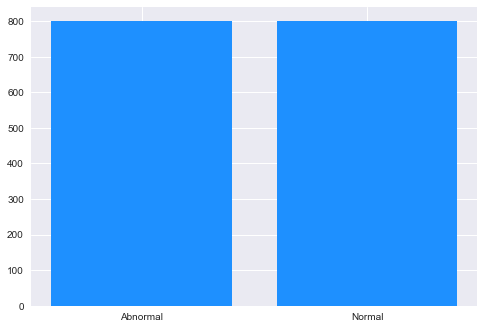

In [2]:

import warnings
warnings.filterwarnings("ignore")
 
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import tensorflow as tf
import seaborn as sns
import keras
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense,Conv1D,Conv1DTranspose,Dropout
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve,confusion_matrix

num_normal = np.sum(d['Class'] == 0)
num_abnormal = np.sum(d['Class'] == 1)
plt.bar(['Abnormal', 'Normal'], [num_abnormal, num_normal], color='dodgerblue')
plt.show()

In [3]:
# 提取负样本，并且按照8:2切成训练集和测试集
data = d
mask = (data['Class'] == 0)

X_train, X_test = train_test_split(data[mask], test_size=0.2, random_state=920)

X_train = X_train.drop(['Class'], axis=1).values
X_test = X_test.drop(['Class'], axis=1).values

# 提取所有正样本，作为测试集的一部分
X_fraud = data[~mask].drop(['Class'], axis=1).values


In [4]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)
X_fraud=X_fraud.reshape(X_fraud.shape[0],X_fraud.shape[1],1)
print(X_test.shape,X_train.shape)

(160, 28, 1) (640, 28, 1)


In [5]:
model = keras.Sequential(
    [
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        Dropout(rate=0.2),
        Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        Dropout(rate=0.2),
        Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 14, 32)            256       
_________________________________________________________________
dropout (Dropout)            (None, 14, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7, 16)             3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 14, 16)            1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 16)            0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 28, 32)            3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 28, 1)             2

In [6]:
checkpointer = ModelCheckpoint(filepath="conv.h5",
                               verbose=0,
                               save_best_only=True)
history = model.fit(
    X_train,
    X_train,
    shuffle=True,
    epochs=500,
    batch_size=64,
    verbose=1, 
    validation_data=(X_test, X_test),
    callbacks=[checkpointer]).history


Epoch 1/500
10/10 [==============================] - 0s 34ms/step - loss: 0.1500 - mae: 0.2972 - val_loss: 0.0679 - val_mae: 0.2043
Epoch 2/500
10/10 [==============================] - 0s 9ms/step - loss: 0.0780 - mae: 0.2252 - val_loss: 0.0654 - val_mae: 0.1950
Epoch 3/500
10/10 [==============================] - 0s 8ms/step - loss: 0.0680 - mae: 0.2005 - val_loss: 0.0575 - val_mae: 0.1872
Epoch 4/500
10/10 [==============================] - 0s 8ms/step - loss: 0.0605 - mae: 0.1973 - val_loss: 0.0503 - val_mae: 0.1761
Epoch 5/500
10/10 [==============================] - 0s 9ms/step - loss: 0.0513 - mae: 0.1783 - val_loss: 0.0410 - val_mae: 0.1590
Epoch 6/500
10/10 [==============================] - 0s 9ms/step - loss: 0.0422 - mae: 0.1625 - val_loss: 0.0323 - val_mae: 0.1386
Epoch 7/500
10/10 [==============================] - 0s 8ms/step - loss: 0.0355 - mae: 0.1475 - val_loss: 0.0260 - val_mae: 0.1237
Epoch 8/500
10/10 [==============================] - 0s 8ms/step - loss: 0.0312 - 

10/10 [==============================] - 0s 5ms/step - loss: 0.0067 - mae: 0.0620 - val_loss: 0.0027 - val_mae: 0.0395
Epoch 64/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0067 - mae: 0.0620 - val_loss: 0.0028 - val_mae: 0.0409
Epoch 65/500
10/10 [==============================] - 0s 8ms/step - loss: 0.0067 - mae: 0.0620 - val_loss: 0.0022 - val_mae: 0.0357
Epoch 66/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0066 - mae: 0.0615 - val_loss: 0.0025 - val_mae: 0.0383
Epoch 67/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0064 - mae: 0.0610 - val_loss: 0.0029 - val_mae: 0.0410
Epoch 68/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0065 - mae: 0.0611 - val_loss: 0.0026 - val_mae: 0.0397
Epoch 69/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0065 - mae: 0.0615 - val_loss: 0.0024 - val_mae: 0.0377
Epoch 70/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0064 - mae: 0

Epoch 125/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0047 - mae: 0.0516 - val_loss: 0.0032 - val_mae: 0.0435
Epoch 126/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0047 - mae: 0.0515 - val_loss: 0.0033 - val_mae: 0.0435
Epoch 127/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0045 - mae: 0.0509 - val_loss: 0.0037 - val_mae: 0.0465
Epoch 128/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0045 - mae: 0.0512 - val_loss: 0.0030 - val_mae: 0.0414
Epoch 129/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0045 - mae: 0.0510 - val_loss: 0.0044 - val_mae: 0.0512
Epoch 130/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0044 - mae: 0.0504 - val_loss: 0.0035 - val_mae: 0.0446
Epoch 131/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0045 - mae: 0.0508 - val_loss: 0.0042 - val_mae: 0.0503
Epoch 132/500
10/10 [==============================] - 0s 7ms/step - 

10/10 [==============================] - 0s 6ms/step - loss: 0.0034 - mae: 0.0445 - val_loss: 0.0042 - val_mae: 0.0481
Epoch 187/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0035 - mae: 0.0447 - val_loss: 0.0042 - val_mae: 0.0485
Epoch 188/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0035 - mae: 0.0448 - val_loss: 0.0055 - val_mae: 0.0566
Epoch 189/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0034 - mae: 0.0441 - val_loss: 0.0045 - val_mae: 0.0504
Epoch 190/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0034 - mae: 0.0443 - val_loss: 0.0037 - val_mae: 0.0451
Epoch 191/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0035 - mae: 0.0445 - val_loss: 0.0046 - val_mae: 0.0507
Epoch 192/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0034 - mae: 0.0438 - val_loss: 0.0057 - val_mae: 0.0577
Epoch 193/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0034 -

Epoch 248/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0029 - mae: 0.0405 - val_loss: 0.0045 - val_mae: 0.0496
Epoch 249/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0028 - mae: 0.0403 - val_loss: 0.0055 - val_mae: 0.0556
Epoch 250/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0028 - mae: 0.0397 - val_loss: 0.0050 - val_mae: 0.0531
Epoch 251/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0028 - mae: 0.0400 - val_loss: 0.0041 - val_mae: 0.0475
Epoch 252/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0028 - mae: 0.0401 - val_loss: 0.0040 - val_mae: 0.0470
Epoch 253/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0028 - mae: 0.0401 - val_loss: 0.0042 - val_mae: 0.0481
Epoch 254/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0028 - mae: 0.0399 - val_loss: 0.0046 - val_mae: 0.0503
Epoch 255/500
10/10 [==============================] - 0s 5ms/step - 

10/10 [==============================] - 0s 6ms/step - loss: 0.0024 - mae: 0.0366 - val_loss: 0.0045 - val_mae: 0.0492
Epoch 310/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0024 - mae: 0.0371 - val_loss: 0.0043 - val_mae: 0.0487
Epoch 311/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0024 - mae: 0.0371 - val_loss: 0.0044 - val_mae: 0.0488
Epoch 312/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0024 - mae: 0.0370 - val_loss: 0.0042 - val_mae: 0.0480
Epoch 313/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0025 - mae: 0.0373 - val_loss: 0.0047 - val_mae: 0.0505
Epoch 314/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0025 - mae: 0.0374 - val_loss: 0.0048 - val_mae: 0.0510
Epoch 315/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0025 - mae: 0.0375 - val_loss: 0.0042 - val_mae: 0.0481
Epoch 316/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0024 -

10/10 [==============================] - 0s 5ms/step - loss: 0.0023 - mae: 0.0355 - val_loss: 0.0051 - val_mae: 0.0529
Epoch 371/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0022 - mae: 0.0353 - val_loss: 0.0052 - val_mae: 0.0535
Epoch 372/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0022 - mae: 0.0354 - val_loss: 0.0048 - val_mae: 0.0517
Epoch 373/500
10/10 [==============================] - 0s 4ms/step - loss: 0.0022 - mae: 0.0352 - val_loss: 0.0044 - val_mae: 0.0493
Epoch 374/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0022 - mae: 0.0352 - val_loss: 0.0042 - val_mae: 0.0483
Epoch 375/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0022 - mae: 0.0350 - val_loss: 0.0044 - val_mae: 0.0492
Epoch 376/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0022 - mae: 0.0352 - val_loss: 0.0040 - val_mae: 0.0468
Epoch 377/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0022 -

Epoch 432/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0020 - mae: 0.0341 - val_loss: 0.0050 - val_mae: 0.0532
Epoch 433/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0021 - mae: 0.0343 - val_loss: 0.0047 - val_mae: 0.0511
Epoch 434/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0020 - mae: 0.0339 - val_loss: 0.0048 - val_mae: 0.0522
Epoch 435/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0020 - mae: 0.0336 - val_loss: 0.0050 - val_mae: 0.0528
Epoch 436/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0020 - mae: 0.0337 - val_loss: 0.0050 - val_mae: 0.0530
Epoch 437/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0021 - mae: 0.0342 - val_loss: 0.0051 - val_mae: 0.0532
Epoch 438/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0020 - mae: 0.0333 - val_loss: 0.0044 - val_mae: 0.0498
Epoch 439/500
10/10 [==============================] - 0s 6ms/step - 

10/10 [==============================] - 0s 6ms/step - loss: 0.0019 - mae: 0.0330 - val_loss: 0.0048 - val_mae: 0.0518
Epoch 494/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0019 - mae: 0.0329 - val_loss: 0.0054 - val_mae: 0.0558
Epoch 495/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0019 - mae: 0.0328 - val_loss: 0.0050 - val_mae: 0.0529
Epoch 496/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0019 - mae: 0.0325 - val_loss: 0.0048 - val_mae: 0.0525
Epoch 497/500
10/10 [==============================] - 0s 5ms/step - loss: 0.0018 - mae: 0.0322 - val_loss: 0.0048 - val_mae: 0.0517
Epoch 498/500
10/10 [==============================] - 0s 7ms/step - loss: 0.0018 - mae: 0.0320 - val_loss: 0.0049 - val_mae: 0.0527
Epoch 499/500
10/10 [==============================] - 0s 8ms/step - loss: 0.0019 - mae: 0.0325 - val_loss: 0.0048 - val_mae: 0.0524
Epoch 500/500
10/10 [==============================] - 0s 6ms/step - loss: 0.0019 -

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


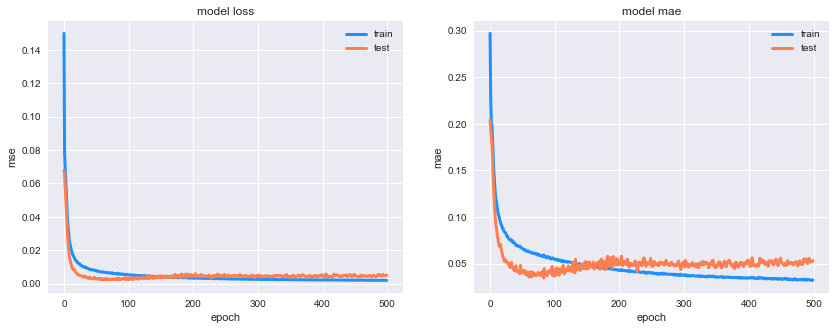

In [8]:
print(history.keys())

# 画出损失函数曲线
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(history['loss'], c='dodgerblue', lw=3)
plt.plot(history['val_loss'], c='coral', lw=3)
plt.title('model loss')
plt.ylabel('mse'); plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.subplot(122)
plt.plot(history['mae'], c='dodgerblue', lw=3)
plt.plot(history['val_mae'], c='coral', lw=3)
plt.title('model mae')
plt.ylabel('mae'); plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [11]:
# 读取模型
print(len(X_train[4]))
autoencoder = load_model('conv.h5')
#pred=autoencoder.predict(X_test[0].reshape(1,29))
#print(pred)
#print(X_test[0].shape)
# 利用训练好的autoencoder重建测试集
pred_test = autoencoder.predict(X_test)
pred_fraud = autoencoder.predict(X_fraud)

# 计算还原误差MSE和MAE
mse_test = np.mean(np.power(X_test - pred_test, 2), axis=1)
mse_fraud = np.mean(np.power(X_fraud - pred_fraud, 2), axis=1)
mae_test = np.mean(np.abs(X_test - pred_test), axis=1)
mae_fraud = np.mean(np.abs(X_fraud - pred_fraud), axis=1)

mse_test=mse_test.reshape(-1)
mse_fraud=mse_fraud.reshape(-1)
mae_test=mae_test.reshape(-1)
mae_fraud=mae_fraud.reshape(-1)

mse_df = pd.DataFrame()
mse_df['Class'] = [0] * len(mse_test) + [1] * len(mse_fraud)
mse_df['MSE'] = np.hstack([mse_test, mse_fraud])
mse_df['MAE'] = np.hstack([mae_test, mae_fraud])
mse_df = mse_df.sample(frac=1).reset_index(drop=True)


28


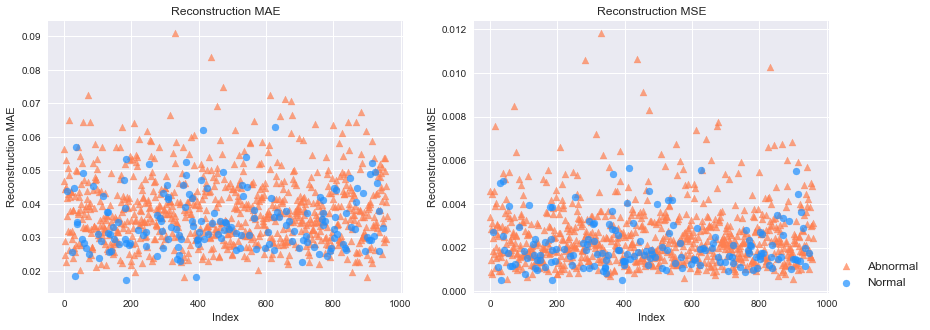

In [12]:
# 分别画出测试集中正样本和负样本的还原误差MAE和MSE
markers = ['o', '^']
markers = ['o', '^']
colors = ['dodgerblue', 'coral']
labels = ['Normal', 'Abnormal']

plt.figure(figsize=(14, 5))
plt.subplot(121)
for flag in [1, 0]:
    temp = mse_df[mse_df['Class'] == flag]
    plt.scatter(temp.index, 
                temp['MAE'],  
                alpha=0.7, 
                marker=markers[flag], 
                c=colors[flag], 
                label=labels[flag])
plt.title('Reconstruction MAE')
plt.ylabel('Reconstruction MAE'); plt.xlabel('Index')
plt.subplot(122)
for flag in [1, 0]:
    temp = mse_df[mse_df['Class'] == flag]
    plt.scatter(temp.index, 
                temp['MSE'],  
                alpha=0.7, 
                marker=markers[flag], 
                c=colors[flag], 
                label=labels[flag])
plt.legend(loc=[1, 0], fontsize=12); plt.title('Reconstruction MSE')
plt.ylabel('Reconstruction MSE'); plt.xlabel('Index')
plt.show()

In [13]:
test_df = pd.DataFrame({'Test MSE': mse_test})
anormaly_df = pd.DataFrame({"Anormaly MSE": mse_fraud})
sum_test=test_df.describe()
sum_test['Anormaly MSE']=anormaly_df.describe()['Anormaly MSE']
display(sum_test)
print(['MAE','MSE'])

,Test MSE,Anormaly MSE
count,160.000000,800.000000
mean,0.002085,0.002569
std,0.001090,0.001445
min,0.000497,0.000573
25%,0.001369,0.001602
50%,0.001746,0.002226
75%,0.002552,0.003117
max,0.005624,0.011806


['MAE', 'MSE']


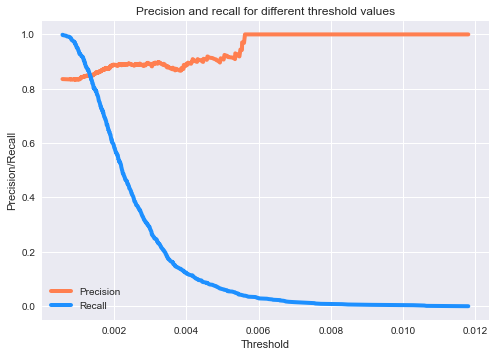

In [14]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(mse_df['Class'], mse_df['MSE'])

plt.plot(threshold_rt, precision_rt[1:], c='coral',label="Precision",linewidth=4)
plt.plot(threshold_rt, recall_rt[1:],c='dodgerblue', label="Recall",linewidth=4)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

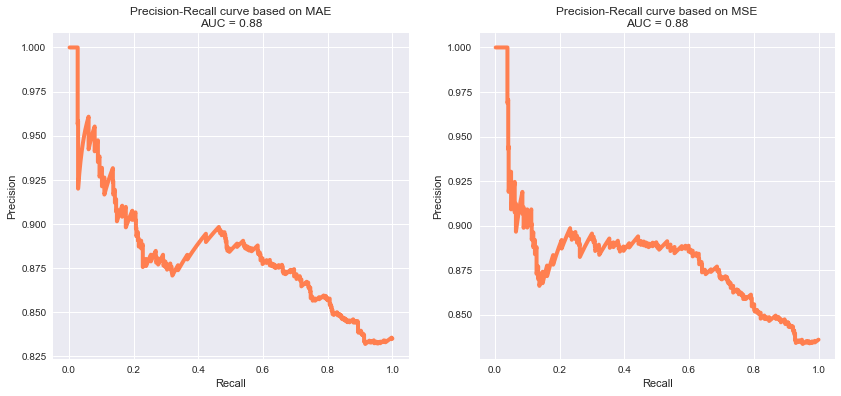

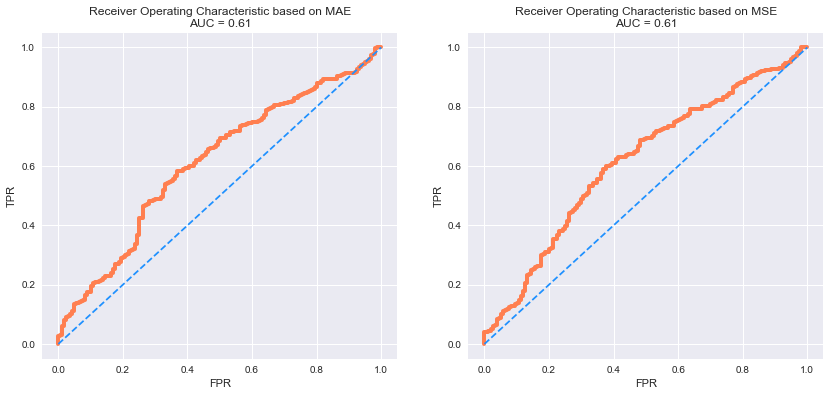

In [15]:
# 画出Precision-Recall曲线
plt.figure(figsize=(14, 6))
for i, metric in enumerate(['MAE', 'MSE']):
    plt.subplot(1, 2, i+1)
    precision, recall, _ = precision_recall_curve(mse_df['Class'], mse_df[metric])
    pr_auc = auc(recall, precision)
    plt.title('Precision-Recall curve based on %s\nAUC = %0.2f'%(metric, pr_auc))
    plt.plot(recall[:-2], precision[:-2], c='coral', lw=4)
    plt.xlabel('Recall'); plt.ylabel('Precision')
plt.show()

# 画出ROC曲线
plt.figure(figsize=(14, 6))
for i, metric in enumerate(['MAE', 'MSE']):
    plt.subplot(1, 2, i+1)
    fpr, tpr, _ = roc_curve(mse_df['Class'], mse_df[metric])
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic based on %s\nAUC = %0.2f'%(metric, roc_auc))
    plt.plot(fpr, tpr, c='coral', lw=4)
    plt.plot([0,1],[0,1], c='dodgerblue', ls='--')
    plt.ylabel('TPR'); plt.xlabel('FPR')
plt.show()

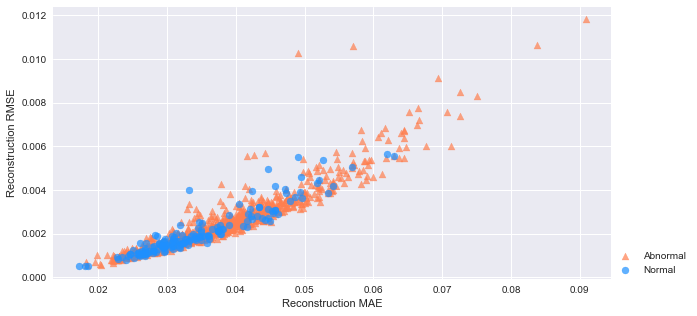

In [16]:
# 画出MSE、MAE散点图
markers = ['o', '^']
colors = ['dodgerblue', 'coral']
labels = ['Normal', 'Abnormal']

plt.figure(figsize=(10, 5))
for flag in [1, 0]:
    temp = mse_df[mse_df['Class'] == flag]
    plt.scatter(temp['MAE'], 
                temp['MSE'],  
                alpha=0.7, 
                marker=markers[flag], 
                c=colors[flag], 
                label=labels[flag])
plt.legend(loc=[1, 0])
plt.ylabel('Reconstruction RMSE'); plt.xlabel('Reconstruction MAE')
plt.show()

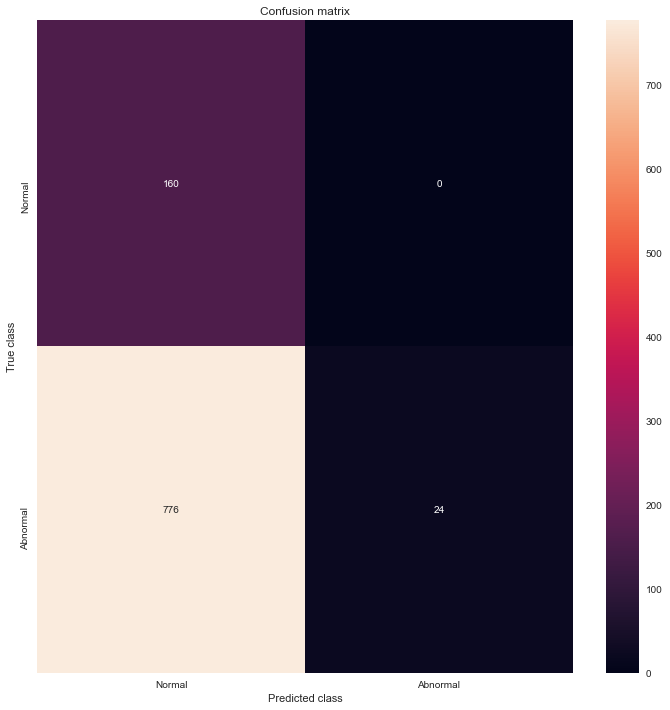

In [17]:
LABELS = ["Normal", "Abnormal"]
threshold_fixed = 0.006
pred_y = [1 if e > threshold_fixed else 0 for e in mse_df['MSE'].values]
conf_matrix = confusion_matrix(mse_df['Class'], pred_y)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()